<h2>DL Group 10</h2>


<table>
  <tr>
    <th>Student Name</th>
    <th>BITS ID</th>
    <th>Contribution</th>
  </tr>
  <tr>
    <td>ADITYA NANDAN REDDY SANIVARAPU</td>
    <td>2022dc04019</td>
    <td>100%</td>
  </tr>
  <tr>
    <td>SANJANA SANJEEV DESHPANDE</td>
    <td>2022dc04091</td>
    <td>100%</td>
  </tr>
  <tr>
    <td>DINESH KUMAR NAYAK</td>
    <td>2022da04293</td>
    <td>100%</td>
  </tr>
</table>

# Multivariate Time Series Forecasting

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Air Pollution Forecasting

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

Attribute Information:

 - No    : row number
 - year  : year of data in this row
 - month : month of data in this row
 - day   : day of data in this row
 - hour  : hour of data in this row
 - pm2.5 : PM2.5 concentration (ug/m^3)
 - DEWP  : Dew Point 
 - TEMP  : Temperature
 - PRES  : Pressure (hPa)
 - cbwd  : Combined wind direction
 - Iws   : Cumulated wind speed (m/s)
 - Is    : Cumulated hours of snow
 - Ir    : Cumulated hours of rain 
 
 Ref: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## Dataset preparation

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], 
                      index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


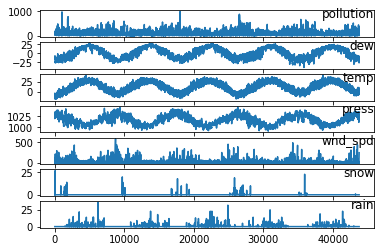

In [3]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [4]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


### Now you have X and y, slice them into training and test dataset.

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
Xtrain, Ytrain = train[:, :-1], train[:, -1]
Xtest, Ytest = test[:, :-1], test[:, -1]

### RNN needs 3D input
# reshape input to be 3D [samples, timesteps, features]
Xtrain = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## GRU RNN

In [7]:
gruModel = keras.models.Sequential()

gruModel.add(keras.layers.GRU(50, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))

gruModel.add(keras.layers.Dense(1))

gruModel.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8850      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,901
Trainable params: 8,901
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 

gruModel.compile(loss='mae', optimizer='adam', metrics=['mae'])

In [9]:
# train the model

history = gruModel.fit(Xtrain, Ytrain, epochs = 50, batch_size=72, validation_split=0.1, verbose=1 )

Train on 7884 samples, validate on 876 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
7884/7884 [==============================] - 3s 351us/sample - loss: 0.0525 - mean_absolute_error: 0.0525 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 2/50
7884/7884 [==============================] - 1s 108us/sample - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 3/50
7884/7884 [==============================] - 1s 135us/sample - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 4/50
7884/7884 [==============================] - 1s 125us/sample - loss: 0.0143 - mean_absolute_error: 0.0143 - val_loss: 0.0150 - val_mean_absolute_error: 0.0150
Epoch 5/50
7884/7884 [==============================] - 1s 116us/sample - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 6/5

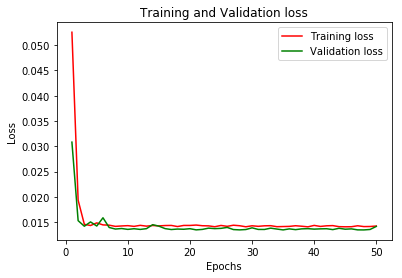

In [10]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [11]:
testResult = gruModel.evaluate(Xtest, Ytest)
print(testResult)

35039/35039 [==============================] - 2s 54us/sample - loss: 0.0133 - mean_absolute_error: 0.0133
[0.013342687144674903, 0.013342683]


# Exercise 

Modify the code as per the below instructions
- Use a different dataset.
- Choose a different embedding like word2vec or gensim, if applicable.
- Modify the architecture, as below
    - Single layer of GRU and FC
    - Two layers of GRU and FC
- Change the number of GRU units in each layer.


### Dataset 

    - Link to download https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip

In [13]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.layers import GRU, Dense, Dropout

def suppress_warnings():
    """
    Suppress DeprecationWarning,UserWarning.
    """
    warnings.filterwarnings("ignore", category=DeprecationWarning) # Suppress Deprecati
    warnings.filterwarnings("ignore", category=UserWarning) # Suppress UserWarni
    warnings.filterwarnings("ignore", category=FutureWarning)
    # Suppress UserWarning for outdated numexpr and bottleneck versions
    warnings.filterwarnings('ignore', message="Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).", category=UserWarning)
    warnings.filterwarnings('ignore', message="Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).", category=UserWarning)
suppress_warnings()



In [2]:
file = "household_power_consumption.txt"
dataset = pd.read_csv(file,
                   parse_dates={'dt' : ['Date', 'Time']},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan','?'],
                   sep=';')
dataset.fillna(0, inplace=True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')

### PreProcessing

In [3]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
missing_values_per_column = dataset.isnull().sum()
print("Missing values per column:")
print(missing_values_per_column)

Missing values per column:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


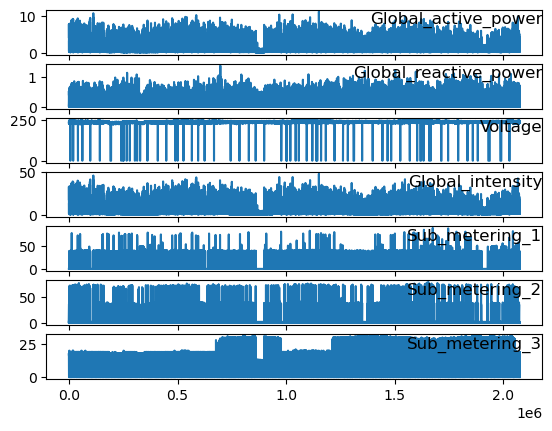

In [6]:
# specify columns to plot
groups = [0, 1, 2, 3, 4,5, 6]
i = 1

# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [7]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset.values)

In [8]:
# Convert time series data into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Concatenate all columns
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)

reframed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075258 entries, 1 to 2075258
Data columns (total 14 columns):
 #   Column     Dtype  
---  ------     -----  
 0   var1(t-1)  float64
 1   var2(t-1)  float64
 2   var3(t-1)  float64
 3   var4(t-1)  float64
 4   var5(t-1)  float64
 5   var6(t-1)  float64
 6   var7(t-1)  float64
 7   var1(t)    float64
 8   var2(t)    float64
 9   var3(t)    float64
 10  var4(t)    float64
 11  var5(t)    float64
 12  var6(t)    float64
 13  var7(t)    float64
dtypes: float64(14)
memory usage: 237.5 MB


In [9]:
# Drop columns we don't want to predict
reframed.drop(reframed.columns[[1,2,3,4]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var6(t-1)  var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)  \
1   0.379069     0.0125   0.548387  0.481928  0.313669  0.919260  0.475207   
2   0.481928     0.0125   0.516129  0.483186  0.358273  0.917922  0.475207   
3   0.483186     0.0250   0.548387  0.484445  0.361151  0.919693  0.475207   
4   0.484445     0.0125   0.548387  0.329617  0.379856  0.927326  0.326446   
5   0.329617     0.0125   0.548387  0.316490  0.375540  0.924729  0.309917   

   var5(t)  var6(t)   var7(t)  
1      0.0   0.0125  0.516129  
2      0.0   0.0250  0.548387  
3      0.0   0.0125  0.548387  
4      0.0   0.0125  0.548387  
5      0.0   0.0250  0.548387  


In [10]:
# Split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [11]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(8760, 1, 9) (8760,) (2066498, 1, 9) (2066498,)


### Define model architectures

In [14]:
# Single layer of GRU and FC
model_single_layer = keras.models.Sequential()
model_single_layer.add(keras.layers.GRU(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model_single_layer.add(Dropout(0.2))  # Adding dropout with rate 0.2
model_single_layer.add(keras.layers.Dense(1))
model_single_layer.compile(loss='mae', optimizer='adam')
model_single_layer.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 100)               33300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 33401 (130.47 KB)
Trainable params: 33401 (130.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Train models
history_single_layer = model_single_layer.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/50

122/122 [==============================] - 36s 280ms/step - loss: 0.1471 - val_loss: 0.0415
Epoch 2/50
122/122 [==============================] - 34s 283ms/step - loss: 0.0481 - val_loss: 0.0285
Epoch 3/50
122/122 [==============================] - 36s 297ms/step - loss: 0.0350 - val_loss: 0.0225
Epoch 4/50
122/122 [==============================] - 40s 334ms/step - loss: 0.0278 - val_loss: 0.0239
Epoch 5/50
122/122 [==============================] - 45s 371ms/step - loss: 0.0255 - val_loss: 0.0220
Epoch 6/50
122/122 [==============================] - 39s 324ms/step - loss: 0.0252 - val_loss: 0.0238
Epoch 7/50
122/122 [==============================] - 42s 350ms/step - loss: 0.0218 - val_loss: 0.0221
Epoch 8/50
122/122 [==============================] - 44s 367ms/step - loss: 0.0209 - val_loss: 0.0220
Epoch 9/50
122/122 [==============================] - 36s 302ms/step - loss: 0.0203 - val_loss: 0.0273
Epoch 10/50
122/122 [==============================] - 37s 303ms/step - 

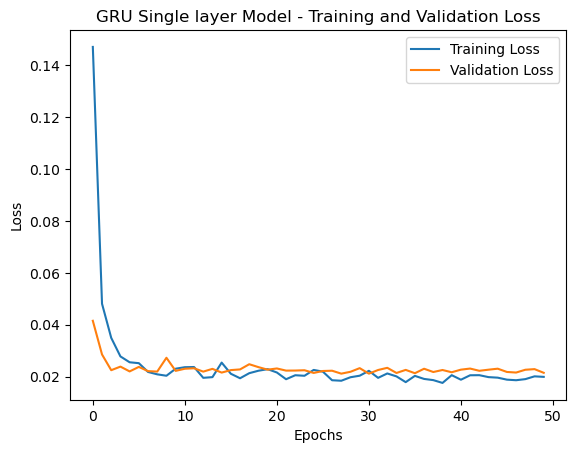

In [16]:
# Plot training and validation loss
plt.plot(history_single_layer.history['loss'], label='Training Loss')
plt.plot(history_single_layer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Single layer Model - Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
testResult = model_single_layer.evaluate(test_X, test_y)
print(testResult)

64579/64579 [==============================] - 90s 1ms/step - loss: 0.0215
0.021477648988366127


In [18]:
# Two layers of GRU and FC
model_two_layers = keras.models.Sequential()
model_two_layers.add(keras.layers.GRU(150, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_single_layer.add(Dropout(0.2))  # Adding dropout with rate 0.2
model_two_layers.add(keras.layers.GRU(100))
model_single_layer.add(Dropout(0.2))  # Adding dropout with rate 0.2
model_two_layers.add(keras.layers.Dense(1))
model_two_layers.compile(loss='mae', optimizer='adam')
model_two_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 1, 150)            72450     
                                                                 
 gru_3 (GRU)                 (None, 100)               75600     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 148151 (578.71 KB)
Trainable params: 148151 (578.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_two_layers = model_two_layers.fit(train_X, train_y, epochs=50, batch_size=100,
                                          validation_data=(test_X, test_y),
                                          callbacks=[early_stopping],
                                          verbose=1, shuffle=False)

Epoch 1/50
88/88 [==============================] - 52s 548ms/step - loss: 0.1395 - val_loss: 0.0389
Epoch 2/50
88/88 [==============================] - 50s 571ms/step - loss: 0.0436 - val_loss: 0.0458
Epoch 3/50
88/88 [==============================] - 46s 526ms/step - loss: 0.0243 - val_loss: 0.0387
Epoch 4/50
88/88 [==============================] - 46s 533ms/step - loss: 0.0239 - val_loss: 0.0324
Epoch 5/50
88/88 [==============================] - 44s 511ms/step - loss: 0.0271 - val_loss: 0.0335
Epoch 6/50
88/88 [==============================] - 45s 519ms/step - loss: 0.0293 - val_loss: 0.0255
Epoch 7/50
88/88 [==============================] - 52s 600ms/step - loss: 0.0179 - val_loss: 0.0220
Epoch 8/50
88/88 [==============================] - 54s 617ms/step - loss: 0.0187 - val_loss: 0.0239
Epoch 9/50
88/88 [==============================] - 55s 630ms/step - loss: 0.0185 - val_loss: 0.0261
Epoch 10/50
88/88 [==============================] - 51s 590ms/step - loss: 0.0164 - val_lo

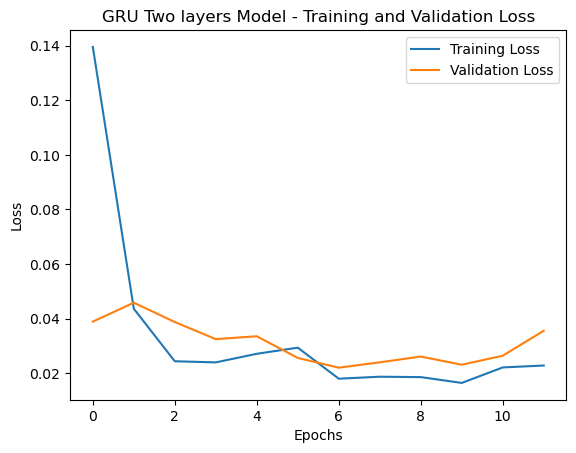

In [20]:
# Plot training and validation loss
plt.plot(history_two_layers.history['loss'], label='Training Loss')
plt.plot(history_two_layers.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Two layers Model - Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
testResult = model_two_layers.evaluate(test_X, test_y)
print(testResult)

64579/64579 [==============================] - 134s 2ms/step - loss: 0.0220
0.021976569667458534


In [22]:
history_two_layers = model_two_layers.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/50
122/122 [==============================] - 64s 533ms/step - loss: 0.0234 - val_loss: 0.0258
Epoch 2/50
122/122 [==============================] - 62s 510ms/step - loss: 0.0235 - val_loss: 0.0268
Epoch 3/50
122/122 [==============================] - 58s 477ms/step - loss: 0.0200 - val_loss: 0.0290
Epoch 4/50
122/122 [==============================] - 63s 520ms/step - loss: 0.0239 - val_loss: 0.0227
Epoch 5/50
122/122 [==============================] - 58s 480ms/step - loss: 0.0210 - val_loss: 0.0272
Epoch 6/50
122/122 [==============================] - 60s 495ms/step - loss: 0.0206 - val_loss: 0.0303
Epoch 7/50
122/122 [==============================] - 61s 500ms/step - loss: 0.0221 - val_loss: 0.0215
Epoch 8/50
122/122 [==============================] - 54s 447ms/step - loss: 0.0168 - val_loss: 0.0260
Epoch 9/50
122/122 [==============================] - 55s 456ms/step - loss: 0.0197 - val_loss: 0.0241
Epoch 10/50
122/122 [==============================] - 61s 500ms/step - l

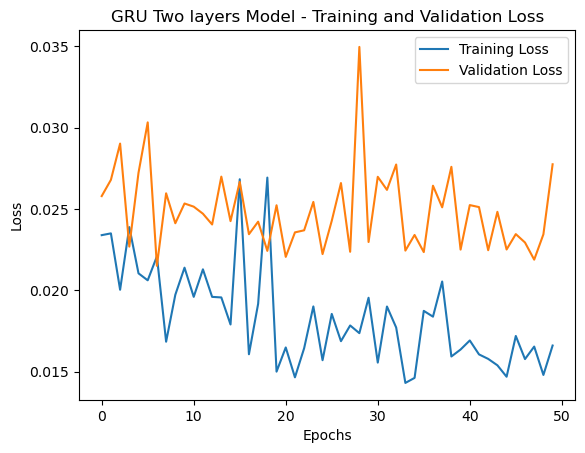

In [23]:
# Plot training and validation loss
plt.plot(history_two_layers.history['loss'], label='Training Loss')
plt.plot(history_two_layers.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Two layers Model - Training and Validation Loss')
plt.legend()
plt.show()

In [24]:
testResult = model_two_layers.evaluate(test_X, test_y)
print(testResult)

64579/64579 [==============================] - 125s 2ms/step - loss: 0.0278
0.02775483764708042


### Summary - Upon comparing the two models, it's evident that both architectures perform similarly in terms of test results, with minor differences observed. Considering the negligible difference in test results, other factors such as computational complexity and training time may influence the choice between these two architectures.For experimental purpose model2 trained multiple times and results are shown. As we observed that running with early stopping training provides better results (as it avoids overfitting) compared to running all epochs. 